# Texture Index

The texture index (TI) is given by the standard deviation of a unit's response to a varity of images with different textures, divided by the standard deviation of its response to shapes.

This is plotted against FOI for different networks.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import handytools.navigator as nav
import handytools.visualizer as vis
from spectools.stimulus.wyeth import get_stimulus
from spectools.responses import get_response_wrapper, get_drr_wrapper
from spectools.metrics.metrics import responsive
from spectools.models.models import AN_layer, VGG16b_layer, ResNet18_layer

In [3]:
def get_prs(R_fills, R_outlines, hkeys, verbose=False):
    prs = {}
    respdic = {}
    for hkey in hkeys:
        R_fill = R_fills[hkey]
        R_outline = R_outlines[hkey]

        prs[hkey] = np.array([])
        respdic[hkey] = []
        
        for unit in range(R_fill.shape[0]):
            resp = responsive(R_fill[unit]) and responsive(R_outline[unit])
            if resp:
                pr = np.corrcoef(R_fill[unit], R_outline[unit])[0][1]
                prs[hkey] = np.append(prs[hkey], pr)
                respdic[hkey].append(int(unit))
            else:
                prs[hkey] = np.append(prs[hkey], np.nan)
                if verbose: print(f"Layer {hkey}, unit {unit} not responsive!")
    return prs, respdic

## AlexNet

In [4]:
# params
hkeys = list(AN_layer.keys())
mtype = "AN"

In [5]:
TI = {}
for hkey in hkeys:
    Rc = nav.npload(nav.resultpath, f"responses_{mtype}", f"hkey={hkey}_TK_norm=standard.npy") # originally TKRc
    TI[hkey] = []

    for Runit in Rc:
        Rshape = Runit[:225]
        Rtexture = Runit[225:]
        TI[hkey].append(np.std(Rtexture)/np.std(Rshape))

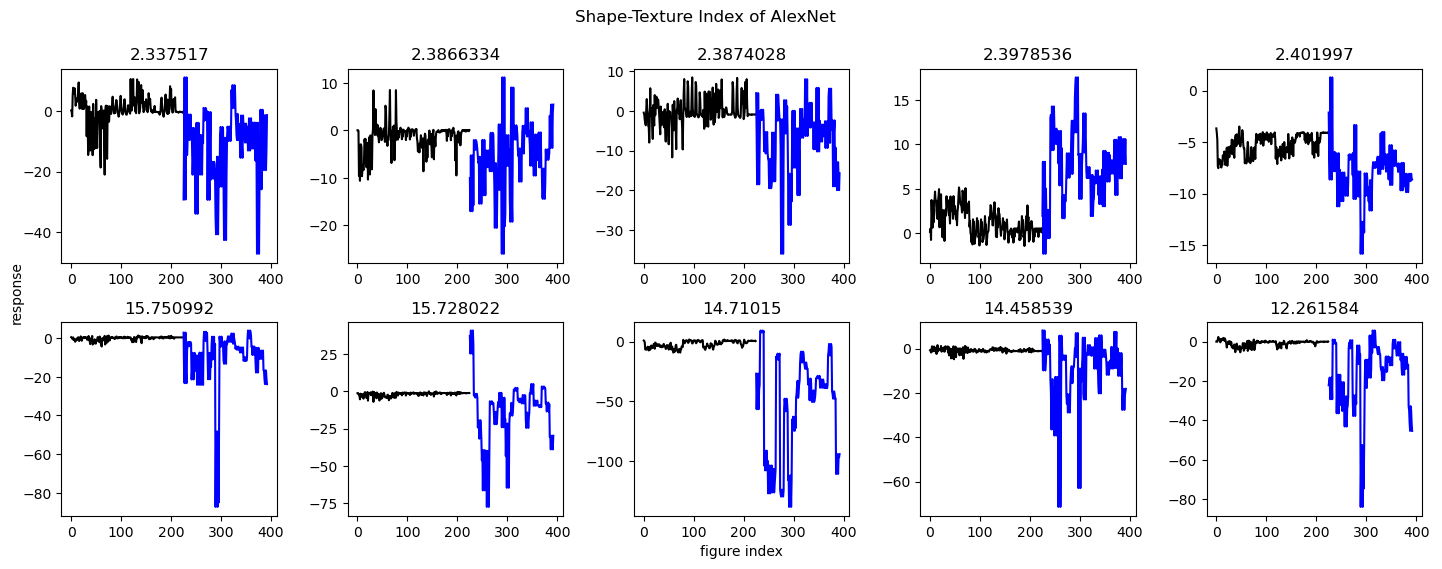

In [6]:
hkey = 3
Rc = nav.npload(nav.resultpath, f"responses_{mtype}", f"hkey={hkey}_TK_norm=standard.npy")
idx_ti = np.argsort(TI[hkey])

fig = plt.figure(figsize=(5*3, 2*3))
for i in range(5):
    ax = fig.add_subplot(2, 5, i+1)
    Runit = Rc[idx_ti[i]]
    Rshape = Runit[:225]
    Rtexture = Runit[225:]
    ax.plot(range(225), Rshape, "k-")
    ax.plot(range(225, 393), Rtexture, "b-")
    ax.set_title(TI[hkey][idx_ti[i]])

for j in range(1, 6):
    ax = fig.add_subplot(2, 5, i+j+1)
    Runit = Rc[idx_ti[-j]]
    Rshape = Runit[:225]
    Rtexture = Runit[225:]
    ax.plot(range(225), Rshape, "k-")
    ax.plot(range(225, 393), Rtexture, "b-")
    ax.set_title(TI[hkey][idx_ti[-j]])

plt.suptitle("Shape-Texture Index of AlexNet")
vis.common_label(fig, "figure index", "response")
plt.tight_layout()

In [7]:
# get foi response
xn, sz, lw, fg, bg = 227, 50, 1.5, 1.0, 0.0
fill = get_stimulus(1, xn=xn, sz=sz, lw=lw, fg=fg, bg=bg)
fname = lambda hkey: f"hkey={hkey}_fill=1_xn={xn}_sz={sz}_lw={lw}_fg={fg}_bg={bg}.npy"
R_fills = get_response_wrapper(hkeys, fill, fname, mtype=mtype)
outline = get_stimulus(0, xn=xn, sz=sz, lw=lw, fg=fg, bg=bg)
fname = lambda hkey: f"hkey={hkey}_fill=0_xn={xn}_sz={sz}_lw={lw}_fg={fg}_bg={bg}.npy"
R_outlines = get_response_wrapper(hkeys, outline, fname, mtype=mtype)
prs_an_foi, resp = get_prs(R_fills, R_outlines, hkeys)

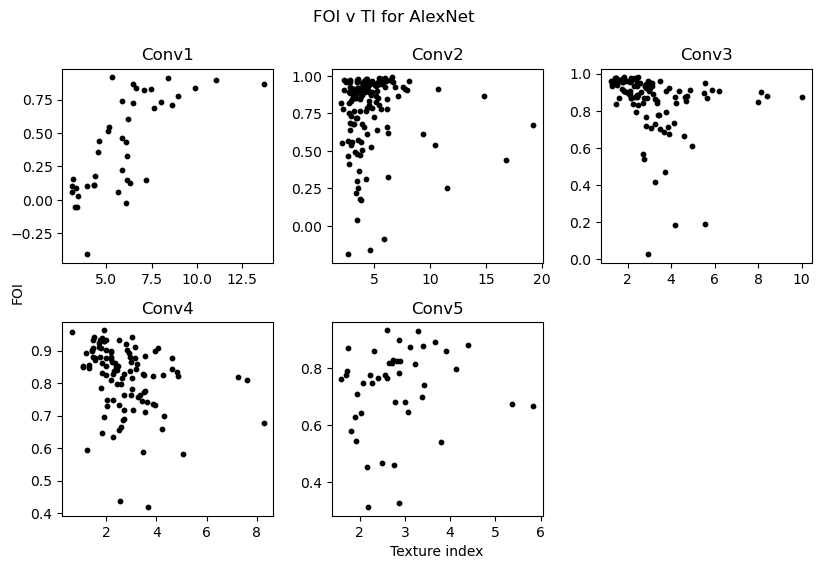

In [8]:
fig = plt.figure(figsize=(3*3, 2*3))

for i in range(len(hkeys)):
    hkey = hkeys[i]
    foi = prs_an_foi[hkey][resp[hkey]]
    ti = np.array(TI[hkey])[resp[hkey]]
    
    ax = fig.add_subplot(2, 3, i+1)
    ax.scatter(ti, foi, color="k", s=10)
    ax.set_title(AN_layer[hkey])

vis.common_label(fig, "Texture index", "FOI")
plt.suptitle("FOI v TI for AlexNet")
plt.tight_layout()

## VGG16

In [4]:
# params
hkeys = list(VGG16b_layer.keys())
mtype = "VGG16b"

In [9]:
TI = {}
func = np.std
for hkey in hkeys:
    Rc = nav.npload(nav.resultpath, f"responses_{mtype}", f"hkey={hkey}_TKRc.npy")
    TI[hkey] = []

    for Runit in Rc:
        Rshape = Runit[:225]
        Rtexture = Runit[225:]
        TI[hkey].append(func(Rtexture)/func(Rshape))

/tmp/ipykernel_118460/2870177750.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  TI[hkey].append(func(Rtexture)/func(Rshape))
/tmp/ipykernel_118460/2870177750.py:10: RuntimeWarning: invalid value encountered in scalar divide
  TI[hkey].append(func(Rtexture)/func(Rshape))


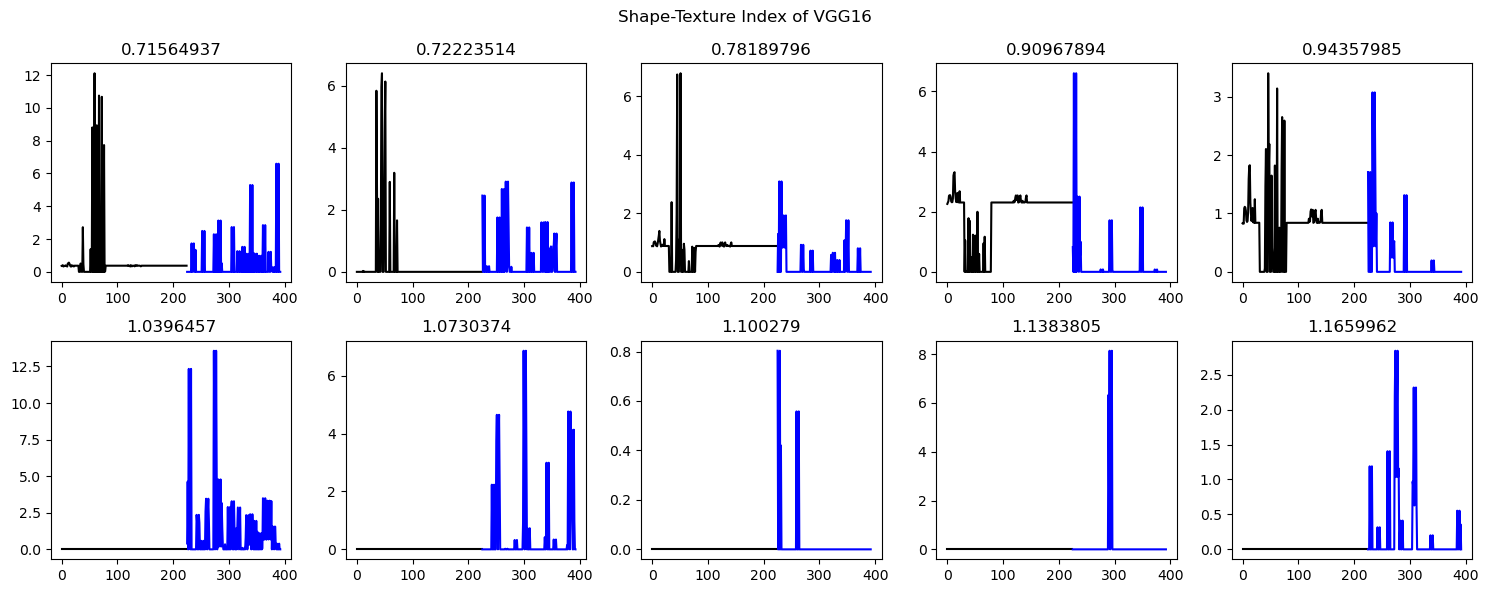

In [10]:
hkey = 10
Rc = nav.npload(nav.resultpath, f"responses_{mtype}", f"hkey={hkey}_TKRc.npy")
idx_ti = np.argsort(TI[hkey])

fig = plt.figure(figsize=(5*3, 2*3))
for i in range(5):
    ax = fig.add_subplot(2, 5, i+1)
    Runit = Rc[idx_ti[i]]
    Rshape = Runit[:225]
    Rtexture = Runit[225:]
    ax.plot(range(225), Rshape, "k-")
    ax.plot(range(225, 393), Rtexture, "b-")
    ax.set_title(TI[hkey][idx_ti[i]])

j = 1
count = 1
while count <= 5:
    Runit = Rc[idx_ti[-j]]

    if np.mean(Runit) != 0:
        Rshape = Runit[:225]
        Rtexture = Runit[225:]
        ax = fig.add_subplot(2, 5, i+count+1)
        ax.plot(range(225), Rshape, "k-")
        ax.plot(range(225, 393), Rtexture, "b-")
        ax.set_title(TI[hkey][idx_ti[i+count+1]])
        count += 1

    j += 1

plt.suptitle("Shape-Texture Index of VGG16")
plt.tight_layout()

In [11]:
# get foi response
xn, sz, lw, fg, bg = 227, 50, 1.5, 1.0, 0.0
fill = get_stimulus(1, xn=xn, sz=sz, lw=lw, fg=fg, bg=bg)
fname = lambda hkey: f"hkey={hkey}_fill=1_xn={xn}_sz={sz}_lw={lw}_fg={fg}_bg={bg}.npy"
R_fills = get_response_wrapper(hkeys, fill, fname, mtype=mtype)
outline = get_stimulus(0, xn=xn, sz=sz, lw=lw, fg=fg, bg=bg)
fname = lambda hkey: f"hkey={hkey}_fill=0_xn={xn}_sz={sz}_lw={lw}_fg={fg}_bg={bg}.npy"
R_outlines = get_response_wrapper(hkeys, outline, fname, mtype=mtype)
prs_vgg16_foi, resp = get_prs(R_fills, R_outlines, hkeys)

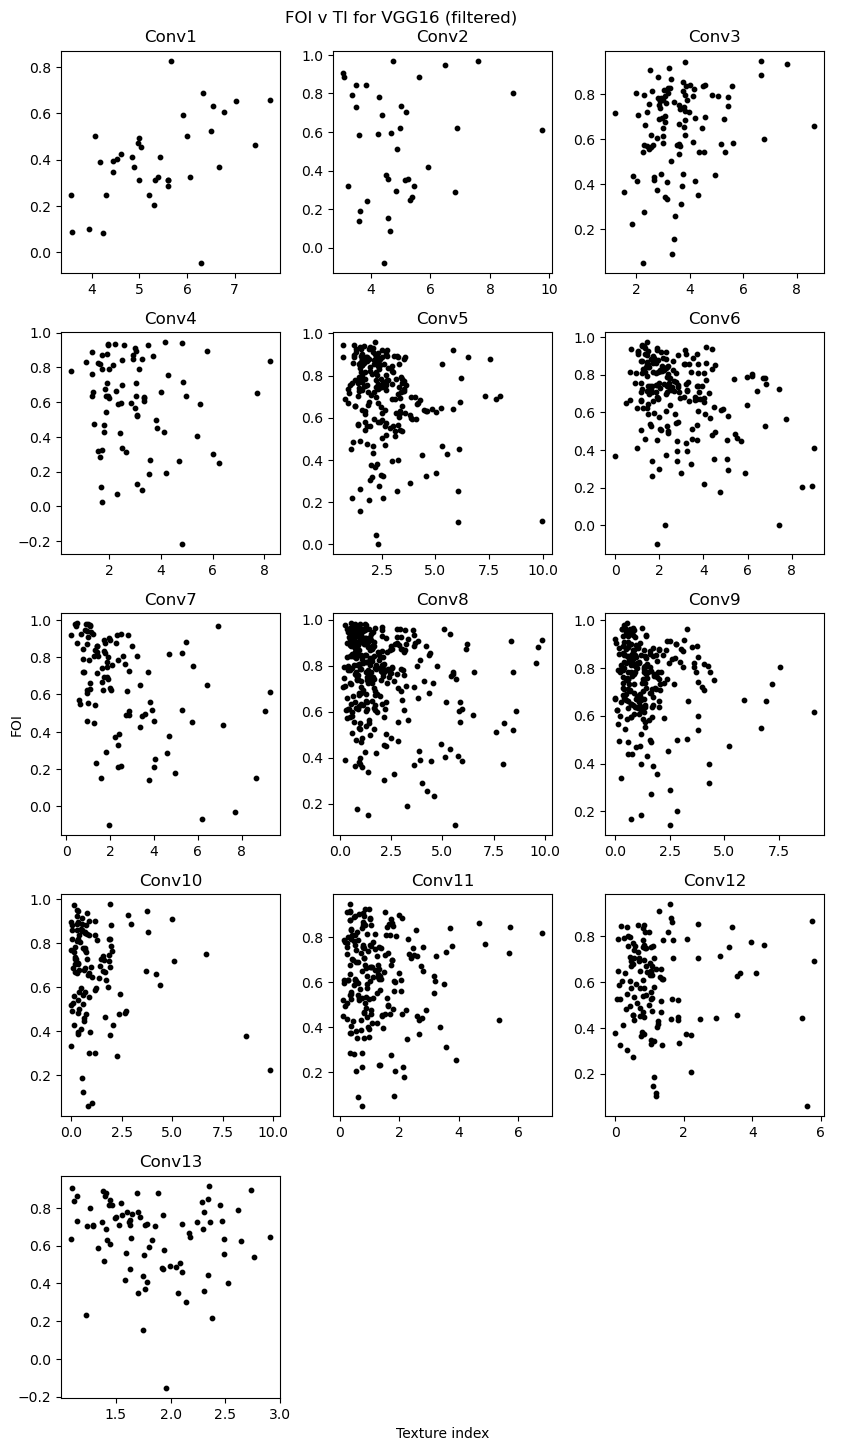

In [12]:
fig = plt.figure(figsize=(3*3, 5*3))

for i in range(len(hkeys)):
    hkey = hkeys[i]
    foi = prs_vgg16_foi[hkey][resp[hkey]]
    ti = np.array(TI[hkey])[resp[hkey]]
    mask = np.where(ti < 10)[0]
    
    ax = fig.add_subplot(5, 3, i+1)
    ax.scatter(ti[mask], foi[mask], color="k", s=10)
    ax.set_title(VGG16b_layer[hkey])

vis.common_label(fig, "Texture index", "FOI")
plt.suptitle("FOI v TI for VGG16 (filtered)")
plt.tight_layout()

## ResNet18

In [4]:
# params
hkeys = list(ResNet18_layer.keys())
mtype = "ResNet18"

In [5]:
TI = {}
for hkey in hkeys:
    Rc = nav.npload(nav.resultpath, f"responses_{mtype}", f"hkey={hkey}_TKRc.npy")
    TI[hkey] = []

    for Runit in Rc:
        Rshape = Runit[:225]
        Rtexture = Runit[225:]
        TI[hkey].append(np.std(Rtexture)/np.std(Rshape))

/tmp/ipykernel_120483/1294394116.py:9: RuntimeWarning: invalid value encountered in scalar divide
  TI[hkey].append(np.std(Rtexture)/np.std(Rshape))
/tmp/ipykernel_120483/1294394116.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  TI[hkey].append(np.std(Rtexture)/np.std(Rshape))


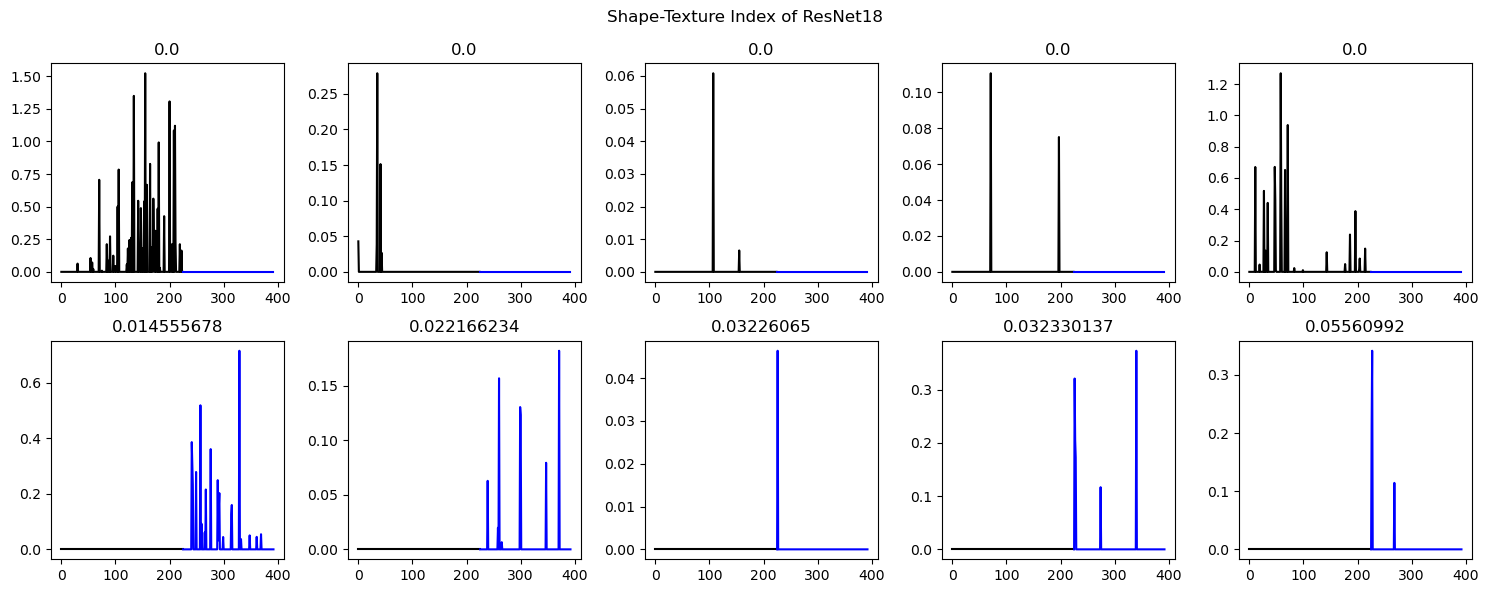

In [7]:
hkey = 10
Rc = nav.npload(nav.resultpath, f"responses_{mtype}", f"hkey={hkey}_TKRc.npy")
idx_ti = np.argsort(TI[hkey])

fig = plt.figure(figsize=(5*3, 2*3))
for i in range(5):
    ax = fig.add_subplot(2, 5, i+1)
    Runit = Rc[idx_ti[i]]
    Rshape = Runit[:225]
    Rtexture = Runit[225:]
    ax.plot(range(225), Rshape, "k-")
    ax.plot(range(225, 393), Rtexture, "b-")
    ax.set_title(TI[hkey][idx_ti[i]])

j = 1
count = 1
while count <= 5:
    Runit = Rc[idx_ti[-j]]

    if np.mean(Runit) != 0:
        Rshape = Runit[:225]
        Rtexture = Runit[225:]
        ax = fig.add_subplot(2, 5, i+count+1)
        ax.plot(range(225), Rshape, "k-")
        ax.plot(range(225, 393), Rtexture, "b-")
        ax.set_title(TI[hkey][idx_ti[i+count+1]])
        count += 1

    j += 1

plt.suptitle("Shape-Texture Index of ResNet18")
plt.tight_layout()

In [11]:
# get foi response
xn, sz, lw, fg, bg = 227, 50, 1.5, 1.0, 0.0
fill = get_stimulus(1, xn=xn, sz=sz, lw=lw, fg=fg, bg=bg)
fname = lambda hkey: f"hkey={hkey}_fill=1_xn={xn}_sz={sz}_lw={lw}_fg={fg}_bg={bg}.npy"
R_fills = get_response_wrapper(hkeys, fill, fname, mtype=mtype)
outline = get_stimulus(0, xn=xn, sz=sz, lw=lw, fg=fg, bg=bg)
fname = lambda hkey: f"hkey={hkey}_fill=0_xn={xn}_sz={sz}_lw={lw}_fg={fg}_bg={bg}.npy"
R_outlines = get_response_wrapper(hkeys, outline, fname, mtype=mtype)
prs_resnet18_foi, resp = get_prs(R_fills, R_outlines, hkeys)

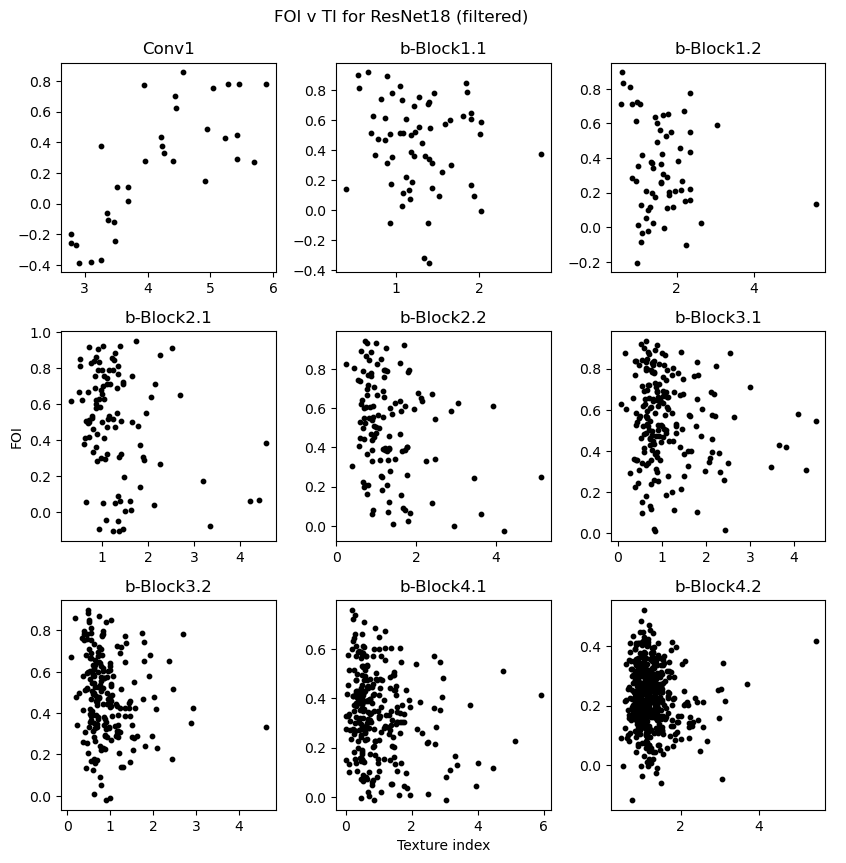

In [18]:
fig = plt.figure(figsize=(3*3, 3*3))

for i in range(len(hkeys)):
    hkey = hkeys[i]
    foi = prs_resnet18_foi[hkey][resp[hkey]]
    ti = np.array(TI[hkey])[resp[hkey]]
    mask = np.where(ti < 6)[0]
    
    ax = fig.add_subplot(3, 3, i+1)
    ax.scatter(ti[mask], foi[mask], color="k", s=10)
    ax.set_title(ResNet18_layer[hkey])

vis.common_label(fig, "Texture index", "FOI")
plt.suptitle("FOI v TI for ResNet18 (filtered)")
plt.tight_layout()